# Sample Code for an Autoencoder for Dr. Goswami
## Shakil Rafi

### Introduction, Dataset, and Methodology

In this notebook we will do a test-case with synthetic data comparing classic PCA with an autoencoder to see that the autoencoder is able to take high-dimensional data and extract out the relevant features. 

**Dataset**

Our dataset will be a synthetic dataset in which we will use tha sklearn datasets method to create eight "blobs" of data and 30,000 observations. Each blob has a centroid around which the data is clustered in a Gaussian fashion with a standard deviation of 2, i.e. each element of the cluster $c$, $x_c$ is such that $x_c \sim \mathcal{N}(\text{centroid}_c,c)$. We will have nine features to the data, to which we will add an extra feature, consisting of noise coming from a uniform distribution.

*Note on dataset*: The author regrets to inform that due to the ongoing shutdowns of internet and communications in Bangladesh that they have had difficulty and delay obtaining actual datasets. This Jupyter notebook therefore serves as a proof of concept that autoencoders can be beneficial and viable in analyzing genomic data via proxy with synthetic data. The author apologizes for this inconvenience.

Finally note we chose autoencoders instead of variational autoencoders. Variational autoencoders are more useful where the underlying dataset is continuous, and are therefore more sutited as generative models for image creation, audio creation, and advanced translation. Our dataset consists of discrete points. The underlying architecture is largely similar. 

Our methodology will be as follows:

![Methodology](methodology.svg)

In summary, we will take our synthetic dataset and perform normalization using the MinMax Scaler. Upon completion of the PCA transform we will perform a scatterplot and perform a basic visual inspection. Ideally, we would expect to see eight clusters, but even here we will see that PCA will fail dramatically. We will then perform a classic k-means clustering on this reduced space. We will then calculate the relevant scores inertia defined as:

$$
\text{Inertia} = \sum^n_{i=1}\sum_{j=1}^k \left\| x_i - \mu_i\right\|^2 \cdot \mathbf{1}_{x_i \in C_i}
$$

where $n$ is the number of data points, $k$ is the number of clusters $\mu_i$ is the centroid of each cluster.

Essentially, the inertial score tells us how "compact" each cluster is. Scores range from $[0,\infty)$. A lower score means a better cluster, although this is not the only metric for measuring clustering effectiveness. One other measure is silhoutte score, defined for a single datapoint $x_i$ as:

$$
\text{Silhoutte}(x_i) = \frac{b(x_i)-a(x_i)}{\max\{a(x_i),b(x_i)\}}
$$

Where $a(x_i)$ is the average distance between $x_i$ and all other points in the cluster, mathematicall speaking, this is:
$$
a(x_i) = \frac{1}{|C_i| -1} \left( \sum_{x_j \in C_k,x_j \neq x_i} \left\| x_i-x_j\right\|\right)
$$

And where $b(x_i)$ is the minimum average distance between $x_i$ and all other points in other clusters, mathematically speaking, this is:

$$
b(x_i) = \min_{C_m \neq C_k} \left( \frac{1}{|C_m|}\sum_{x_j \in C_m}\left\| x_i-x_j\right\|\right)
$$

The silhoutte score method computes the average silhoutte score for each point in the dataset. A score closer to one indicates better clustering, zero indicates average clustering and a score closer to -1 indicates poor clustering. 

In [1]:
####################################################################################
#
# The current cell installs packages if not already installed in the hosts systems.
# This is supplemented by an extensive requirements.txt file in the folder
#
####################################################################################

# import subprocess
# import sys

# def install(package):
#     subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# # List your packages here
# packages = ["numpy", "pandas", "seaborn","keras","tensorflow","matplotlib", "scikit-learn"]

# for package in packages:
#     install(package)


In [2]:
# Import requisite libraries (see cell above)

import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(style='whitegrid')

In [3]:
from sklearn.datasets import make_blobs

In [4]:
# Generate out dataset

data = make_blobs(
    n_samples=30000, 
    n_features=9, 
    centers=8, 
    cluster_std=2
)

X,y = data

In [5]:
# Create a random uniform column of noise to be added as a feature

noise = np.random.uniform(size=len(X))
noise = pd.Series(noise)

In [6]:
# Add noise to our dataset. Note that since no one dimension is any 
# special than another dimension it does not matter where we add
# the noise to

feat = pd.DataFrame(X)
feat = pd.concat([feat,noise],axis=1)

In [7]:
# Rename the columns to be human readable

feat.columns = [f"X{i+1}" for i in range(len(feat.columns))]

In [8]:
# Visually inspect our X

feat

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,-1.136767,-7.536911,2.621168,-9.828140,-3.865670,-1.674786,-5.115837,5.617020,-4.750097,0.642509
1,-2.852468,-5.484812,0.761357,-5.310830,-0.765052,-4.604699,0.802374,6.235689,-7.531256,0.601436
2,5.359061,-9.550195,6.925959,5.607171,-9.007517,-8.092173,-10.609527,0.761276,0.442488,0.143062
3,-1.129229,-6.700314,2.486264,-9.299770,-3.403568,-1.482824,0.175253,7.681944,-5.067821,0.555860
4,0.504382,10.764073,-8.950778,-9.971141,-8.233655,-3.444365,-2.858322,-4.343349,8.237406,0.874118
...,...,...,...,...,...,...,...,...,...,...
29995,1.694952,-5.769989,1.414679,-6.885614,-4.231421,-0.577456,0.401629,8.479906,-9.237994,0.646565
29996,-3.969766,-3.027052,-10.773146,3.785328,-2.319494,-10.762726,7.858389,6.768924,5.738144,0.022102
29997,3.188127,-6.205679,9.776009,5.235112,-5.710168,-3.508407,-9.290813,-3.374623,0.642398,0.683150
29998,-1.153925,1.446702,-5.855636,0.729021,-7.422402,-7.574691,8.517585,12.058961,4.634554,0.711099


In [9]:
# Summary statistics of our dataset for EDA

feat.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000
mean,-0.114208,-1.339915,0.474912,-1.245021,-5.033560,-3.395521,-0.435639,4.535977,0.787082,0.499431
std,3.454144,6.909265,6.218669,5.188529,4.804423,5.925886,7.488308,5.594253,5.795202,0.289262
min,-10.221948,-16.244301,-17.057922,-15.090140,-16.368939,-16.264199,-17.769535,-11.819501,-13.793827,0.000086
25%,-2.744997,-6.664654,-4.094327,-5.957284,-7.975855,-7.623085,-7.214682,0.614334,-4.719394,0.246672
50%,-0.317141,-3.240089,1.654777,-0.661242,-6.152396,-4.735727,-1.561951,6.368589,1.306372,0.499086
75%,2.526472,4.944013,4.568410,2.584007,-3.973561,-1.024333,6.959158,8.578064,5.959517,0.750157
max,11.234515,15.793868,16.281236,13.452604,13.693923,16.438185,16.854938,16.083165,15.460923,0.999996


In [10]:
# Save our dataset

feat.to_csv("feat.csv")

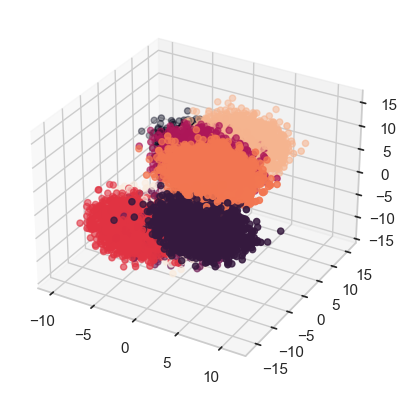

In [11]:
# 3D scatterplot of three arbitrary dimensions 

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(feat['X1'],feat['X2'],feat['X9'], c = y)

### Preprocessing the data

We will use the standard MinMaxScaler from sklearn to scale and preprocess the data

In [12]:
# Preprocess our data using MinMaxScaler

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(feat)

### The PCA decomposition

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

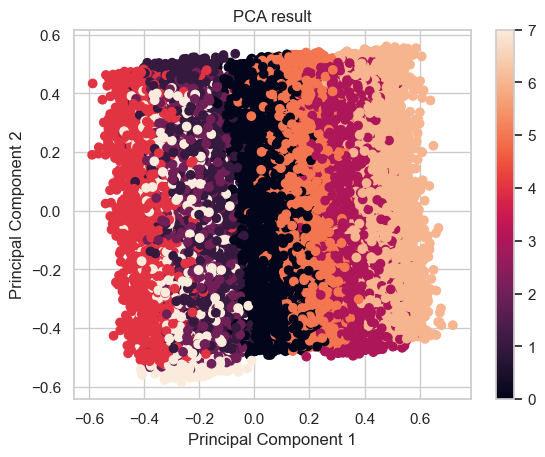

In [14]:
# Scatterplot of our reduced dimensions

plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y)
plt.title('PCA result')
plt.colorbar()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

Note that PCA fails dramatically at this dimension reduction task. A priori we know that this dataset has clusters as it was constructed this way but PCA fails to capture the clustering. This is because PCA is a linear transformation and fails to capture any non-linear trends in the data. Note also that the uniform noise dimension results in a projection that is "smeared" yielding no obvious clusters on visual inspection. We will run two separate metrics later on to show how much more effective autoencoders are than regular PCA as a pre-step towards clustering.

Note also that since we have a dimension of uniform noise there exists an eigenvalue and eigenvector in the direction of the uniform noise. Because PCA is again a linear transformation, that direction of the eigenvecot induces a horizontal "stripe" pattern as seen in the scatterplot.

#### K-means done on the encoded data

We now seek to apply classic K-Means on this PCA-result. We will do the same on the 

In [15]:
from sklearn.cluster import KMeans

In [16]:
kmeans_for_pca = KMeans(n_clusters=8)
kmeans_for_pca.fit(pca_result)

KMeans()

In [17]:
kmeans_for_pca.cluster_centers_

array([[ 0.39484343,  0.30218081],
       [-0.26485402, -0.02386432],
       [ 0.16332751, -0.31207928],
       [ 0.19432675,  0.01805408],
       [-0.23347193, -0.36066989],
       [-0.30190528,  0.30643115],
       [ 0.09516739,  0.35050887],
       [ 0.44616033, -0.23692276]])

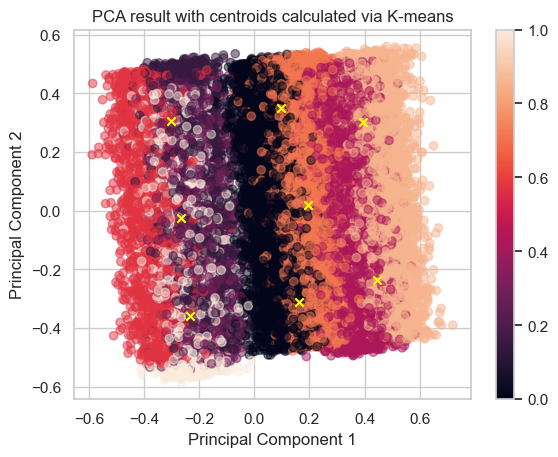

In [18]:
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=y, alpha=0.5)
plt.scatter(kmeans_for_pca.cluster_centers_[:,0],kmeans_for_pca.cluster_centers_[:,1],marker='x',c='yellow')
plt.title('PCA result with centroids calculated via K-means')
plt.colorbar()
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

### The autoencoder decomposition

We will now create an autoencoder. We will choose a rather deep model, with 10 --> 5 --> 2 --> 5 -->10 layer widths. Our autoencoder will first encode the 10 dimensional data to a 2 dimensional latent space, and then decode it back to 10 dimensions. It will be trained against our dataset until it learns an optimal representation for this dataset into two latent dimensions.

We will then extract out the encoder and visually inspect our 2d latent space. Because neural networks are efficient at learning the underlying structure of unstructured data it's latent space should be noise-free, moreso than the PCA representation. As such, even visually we should see much more clustering than with PCA. Schematically, our autoencoder looks as follows:

![Autoencoder](autoencoder.svg)

We will choose the sigmoid function as activation throughout except the last layer of the encoder where we will use the linear activation function. Sigmoid is common in the literature and we will use linear in the last layer so that we may output negative values as well. We will also choose mean squared error loss, with a stochastic gradient descent optimizer and a learning rate of 0.1.

In [19]:
# Load requisite libraries

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import SGD

In [20]:
# Define the input layer
input_layer = Input(shape=(scaled_data.shape[1],))

# Define the encoding layers
encoded = Dense(8, activation='tanh')(input_layer)
encoded = Dense(6, activation='tanh')(encoded)
encoded_output = Dense(2, activation='linear')(encoded)

# Define the encoder model
encoder = Model(inputs=input_layer, outputs=encoded_output)

# Define the decoding layers
encoded_input = Input(shape=(2,))
decoded = Dense(6, activation='tanh')(encoded_input)
decoded = Dense(8, activation='tanh')(decoded)
decoded_output = Dense(scaled_data.shape[1], activation='linear')(decoded)

# Define the decoder model
decoder = Model(inputs=encoded_input, outputs=decoded_output)

# Define the autoencoder model
autoencoder_input = Input(shape=(scaled_data.shape[1],))
encoded_repr = encoder(autoencoder_input)
reconstructed = decoder(encoded_repr)

autoencoder = Model(inputs=autoencoder_input, outputs=reconstructed)

# Print model summaries
print("Encoder summary:")
encoder.summary()
print("\nDecoder summary:")
decoder.summary()
print("\nAutoencoder summary:")
autoencoder.summary()

Encoder summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │            54 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            14 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156 (624.00 B)

 Trainable params: 156 (624.00 B)

 Non-trainable params: 0 (0.00 B)


Decoder summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │            18 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 8)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │            90 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 164 (656.00 B)

 Trainable params: 164 (656.00 B)

 Non-trainable params: 0 (0.00 B)


Autoencoder summary:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional (Functional)         │ (None, 2)              │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_1 (Functional)       │ (None, 10)             │           164 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 320 (1.25 KB)

 Trainable params: 320 (1.25 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:

autoencoder.compile(loss='mse', 
                    optimizer=SGD(learning_rate=0.01))

In [22]:
autoencoder.fit(scaled_data, 
                scaled_data, 
                batch_size = 64,
                shuffle = True,
                epochs = 50)

Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 346us/step - loss: 0.1826
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step - loss: 0.0453
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0379
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 0.0366
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0357
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step - loss: 0.0347
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step - loss: 0.0336
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step - loss: 0.0329
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0322
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0318
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0313
Epoch 12/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 325us/step - loss: 0.0309
Epoch 13/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0307
Epoch 14/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 317us/step - loss: 0.0303
Epoch 15/50
469/469 ━━━━━━━━━

Note that the reconstruction loss here is 0.0389. This is somewhat higher than for PCA although this can be reduced further with more training epochs. The author chose 50 epochs arbitrarily and with consideration for their own access to compute facilities.

In [23]:
# Encode our data down to two dimensions using our
# trained autoencoder

encoded_2dim = encoder.predict(scaled_data)

938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 280us/step


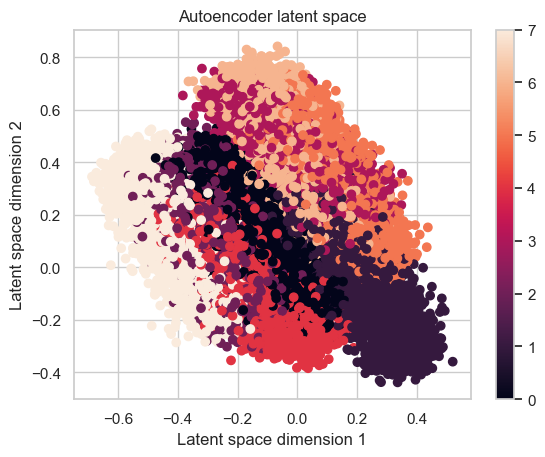

In [24]:
plt.scatter(encoded_2dim[:,0],encoded_2dim[:,1], c = y)
plt.title('Autoencoder latent space')
plt.colorbar()
plt.xlabel("Latent space dimension 1")
plt.ylabel("Latent space dimension 2")
plt.show()

Visually we see that our autoencoder has performed much better than the PCA. We see eight clusters very clearly. Not only that the clusters are much more compact than with PCA, and seem well separated. We will quantify this in the next section.

### Analysis of results

In [25]:
# Train our k-means on the encoded 2 dimensional data

kmeans_for_autoencoder = KMeans(n_clusters=8)
kmeans_for_autoencoder.fit(encoded_2dim)

KMeans()

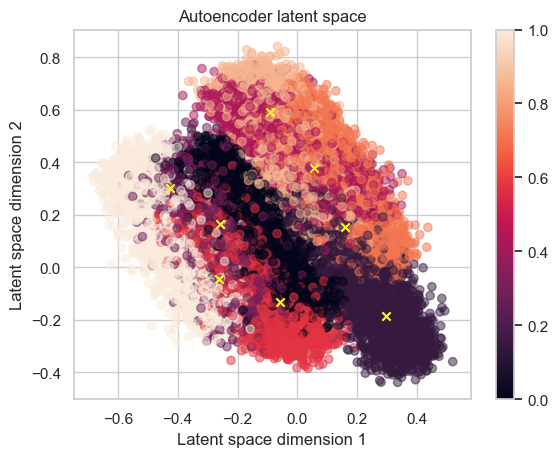

In [26]:
plt.scatter(encoded_2dim[:, 0], encoded_2dim[:, 1], c=y, alpha=0.5)
plt.scatter(kmeans_for_autoencoder.cluster_centers_[:,0],kmeans_for_autoencoder.cluster_centers_[:,1],marker='x',c='yellow')
plt.title('Autoencoder latent space')
plt.colorbar()
plt.xlabel("Latent space dimension 1")
plt.ylabel("Latent space dimension 2")
plt.show()

In [27]:
# Calculating our inertia for the two k-means

print("Inertia for k-means after PCA: ", kmeans_for_pca.inertia_)
print("Inertia for k-means after autoencoder: ", kmeans_for_autoencoder.inertia_)

Inertia for k-means after PCA:  544.2602745173041
Inertia for k-means after autoencoder:  378.1796875


In [28]:
from sklearn.metrics import silhouette_score

print("Silhoutte score for PCA", silhouette_score(scaled_data,kmeans_for_pca.labels_))
print("Silhoutte score for autoencoder", silhouette_score(scaled_data,kmeans_for_autoencoder.labels_))

Silhoutte score for PCA 0.11800770665560721
Silhoutte score for autoencoder 0.08991887959466165


In [29]:
from sklearn.metrics import mean_squared_error

X_reconstructed_from_pca = pca.inverse_transform(pca_result)
X_reconstructed_from_autoencoder = decoder(encoded_2dim)
mean_squared_error(scaled_data, X_reconstructed_from_pca)

0.02361820017793444

##### Saving our models

Finally we will save our model for future use

In [30]:
autoencoder.save("autoencoder.keras")
encoder.save("encoder.keras")
decoder.save("decoder.keras")

In [31]:
import pickle

with open('pca_model.pkl', 'wb') as file:
    pickle.dump(pca, file)

### Summary of results

We give here a table summarizing the results:

| Attribute | PCA | Autoencoder |
|-----|-----|-----|
| **Reconstruction loss**| 0.021 | 0.039 reconstruction loss can be reduced with more trianing epochs |
| **Visual** | No visual separation between clusters | Clear visual separation between clusters|
| **Inertia** lower is better |$\sim 544$ clusters are fall less compact |$\sim 485$ clusters are more compact|
| **Silhoutte Score** closer to 1 is better| $\sim 0.11$ substantial overlap between clusters| $\sim 0.16$ far less overlap between clusters|

These results indicate that autoencoders may be far better and effective methods of pretraining than standard PCA when it comes to clustering algorithms such as k-means. Indeed autoencoders are able to capture non-linearities in data and sus out complex relationships between data that classical methods such as PCA may not be able to. 

This makes autoencoders excellent candidates for dimensionality reduction and analysis for genomic data where high dimensional and intricate relationships exist between features. The field is promising, yet untapped. 